In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as stats

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


import acquire as aq
import prepare as prep

# Preparation

### Reworking a bit of data...
- Since the goal of working with the predictions.csv requires the customer ID column, I decided to rework my aquire.py and prepare.py to fit the needs of the overall project. 
- Below are the results of the dataframe(s) after the rework in the .py files were implemented.

In [2]:
# calling the aquire.py file get_telco_data() function
telco = aq.get_telco_data()

In [3]:
# dropping any duplicate columns : check
telco.drop_duplicates()

# initial overview of the raw telco data retrieved from the SQL
# database

# Here, the idea is to recognize what is needed and what is not.
telco.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [4]:
# Now I check the nulls
telco.isna().sum()

internet_service_type_id    0
payment_type_id             0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
payment_type                0
internet_service_type       0
dtype: int64

### This is where it gets a bit tricky. 
- Ultimately, the gender column will need to be represented in 0's and 1's to properly model them if needed. 
- This is also true when getting certain statistical values on the entire dataframe such as a baseline percentage.

- Certain columns were also replicated into dummy columns and represented by 0's and 1's for later purposes. These columns include:
    - All Contract Types
    - All Payment Types
- Certain columns such as the multiple_lines columns that are objects might cause issues in the future if not fixed now.

In [5]:
# Here I prepared and split the data from my prepare.py file
# function prep_telco()

df = prep.prep_telco(telco)

In [6]:
train, validate, test = df

In [7]:
# for loop of all columns and their dtypes
columns = train.columns
for column in columns:
    if column not in ['customer_id', 'tenure', 'monthly_charges', 'total_charges']:
        print(train[column].value_counts())
        print('---------------------------------------------------')
        print(' ')


Male      1976
Female    1961
Name: gender, dtype: int64
---------------------------------------------------
 
0    3302
1     635
Name: senior_citizen, dtype: int64
---------------------------------------------------
 
0    2027
1    1910
Name: partner, dtype: int64
---------------------------------------------------
 
0    2745
1    1192
Name: dependents, dtype: int64
---------------------------------------------------
 
1    3564
0     373
Name: phone_service, dtype: int64
---------------------------------------------------
 
No                  1895
Yes                 1669
No phone service     373
Name: multiple_lines, dtype: int64
---------------------------------------------------
 
1    2324
0    1613
Name: paperless_billing, dtype: int64
---------------------------------------------------
 
0    2891
1    1046
Name: churn, dtype: int64
---------------------------------------------------
 
Month-to-month    2165
Two year           957
One year           815
Name: contract_type,

### Now to drop duplicate or redundant if needed, and change object columns to integer columns equating 1 = Yes and 0 = No

In [8]:
# mapping gender
train.gender = train.gender.map({'Male':1 , 'Female':0})
train.gender.head()

#mapping yes = 1, no = 1
train.multiple_lines = train.multiple_lines.map({'Yes': 1, 'No': 0,
                                                 'No phone service':2})

# drop columns for which I have a numerical dummy column for
drop_columns = ['contract_type', 'payment_type', 'internet_service_type']
train = train.drop(columns = drop_columns)


### A lot of the columns look a bit funky with their naming conventions, thus they will be renamed to be quickly accessed and recognizable

In [9]:
train = train.rename(columns={'gender': 'is_male',
                              'contract_type_Month-to-month': 'month-to-month_contract',
                             'contract_type_One year': 'one_year_contract',
                              'ontract_type_Two year': 'two_year_contract', 
                              'payment_type_Bank transfer (automatic)': 'bank_transfer_pay',
                              'payment_type_Credit card (automatic)': 'credit_card_pay', 
                              'payment_type_Electronic check': 'electronic_check_pay', 
                              'payment_type_Mailed check': 'mailed_check_pay', 
                              'internet_service_type_DSL': 'DSL_internet', 
                              'internet_service_type_Fiber optic': 'fiber_optic_internet', 
                              'internet_service_type_None': 'no_internet'})

In [10]:
train.head()

,customer_id,is_male,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,...,month-to-month_contract,one_year_contract,contract_type_Two year,bank_transfer_pay,credit_card_pay,electronic_check_pay,mailed_check_pay,DSL_internet,fiber_optic_internet,no_internet
5919,8331-ZXFOE,0,0,0,0,58,1,1,1,71.10,...,0,1,0,0,1,0,0,1,0,0
1915,2790-XUYMV,1,0,0,1,71,1,1,1,85.45,...,0,1,0,0,1,0,0,0,1,0
5054,7107-UBYKY,0,0,1,1,35,1,1,1,25.75,...,1,0,0,0,0,1,0,0,0,1
2355,3373-YZZYM,1,0,1,1,1,1,0,0,19.20,...,1,0,0,0,0,0,1,0,0,1
6279,8883-GRDWQ,1,1,0,0,20,1,0,0,54.00,...,0,1,0,0,0,0,1,1,0,0


# Exploring the Data
- Taking note of the few touches I will need to make later, let's just move right in into exploring the data to get an overall sense of what's to come.

## The Goal :

### The goal is to discover features that have the largest impact on the target variable Churn, i.e. provide the most information gain, drive the outcome, and given indepth insight on what direction we can take to reduce it.


### Questions to look for during exploration : 
- Is there unexpected services related to churn, and why? 
- Are those who use mailed checks for payments more or less likely to churn?
- Do customers who have dependents more likely to have longer tenure than those who do not? 
- On average when do month to month customers churn? Is there a significant pattern of churns around a certain amount of tenure? 

In [11]:
# Exploring churn vs telco
# when getting value counts, normalize will return a percentage
train.churn.value_counts(normalize = True)

0    0.734315
1    0.265685
Name: churn, dtype: float64

In [12]:
# realized values
train.churn.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

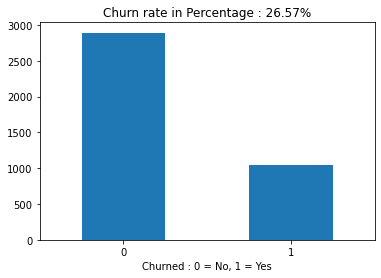

In [13]:
has_churned = (train.churn.mean() * 100)

percent = "{:.2f}".format(has_churned)

train.churn.value_counts().sort_index().plot.bar()
plt.title(f'Churn rate in Percentage : {percent}%')
plt.xlabel('Churned : 0 = No, 1 = Yes')
plt.xticks(rotation = 0)
plt.show()

### Takeaway : 
-  26% of Telco customers have churned.
- Now let's figure out what features drive churn.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3937 non-null   object 
 1   is_male                  3937 non-null   int64  
 2   senior_citizen           3937 non-null   int64  
 3   partner                  3937 non-null   int64  
 4   dependents               3937 non-null   int64  
 5   tenure                   3937 non-null   int64  
 6   phone_service            3937 non-null   int64  
 7   multiple_lines           3937 non-null   int64  
 8   paperless_billing        3937 non-null   int64  
 9   monthly_charges          3937 non-null   float64
 10  total_charges            3937 non-null   float64
 11  churn                    3937 non-null   int64  
 12  month-to-month_contract  3937 non-null   uint8  
 13  one_year_contract        3937 non-null   uint8  
 14  contract_type_Two yea

Text(0, 0.5, 'Features')

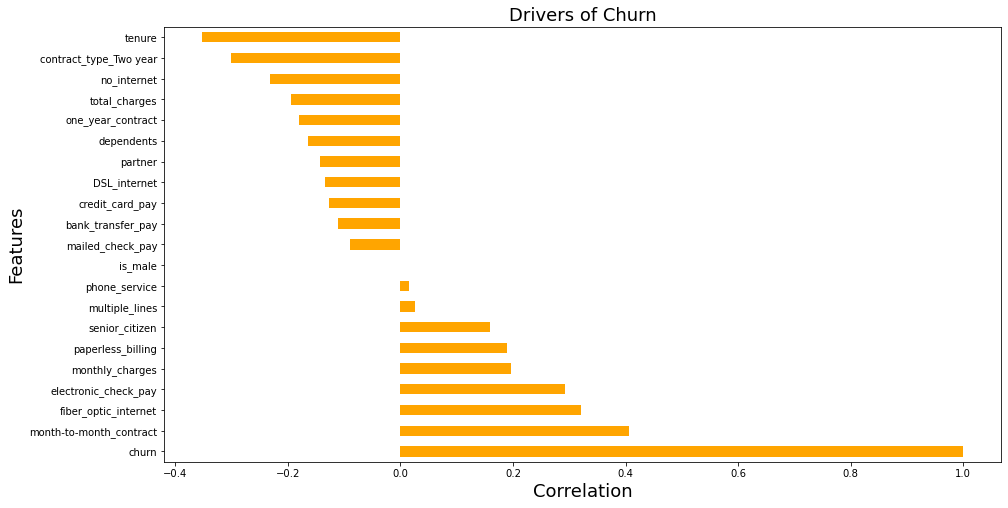

In [15]:
plt.figure(figsize= (15, 8))

train.corr()['churn'].sort_values(ascending=False).plot(kind='barh', 
                                                    color = 'orange')

plt.title('Drivers of Churn', fontsize = 18)
plt.xlabel('Correlation', fontsize = 18)
plt.ylabel('Features', fontsize = 18)

## Takeaways : 
- The strongest features with correlations to churn:
    - Month-to-month contracts
    - Fiber optic internet service types
    - Electronic Check Payment Types
    - Monthly charges
    - And perhaps paperless billing
- *While senior citizen is also very much correlated to churn this top five potentially yields the best data.* 

- Tenure, 2 year contracts, total charges and yearly contracts have a strong negative correlation with churn.
- **Sex has no correlation with churn both negative or positive**

### The big questions : 
- Is there unexpected services related to churn, and why? 
- Are those who use mailed checks for payments more or less likely to churn?
- Do customers who have dependents more likely to have longer tenure than those who do not? 
- On average when do month to month customers churn? Is there a significant pattern of churns around a certain amount of tenure? 

### First, let's take a look at each feature and how they relate to churn:

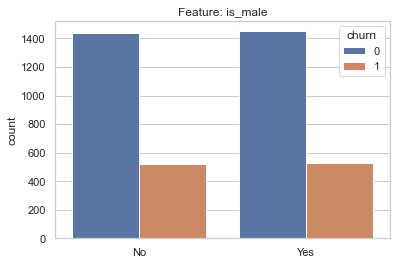

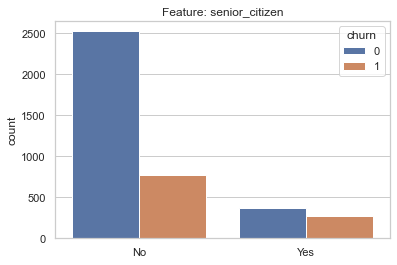

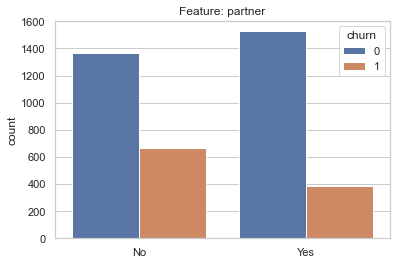

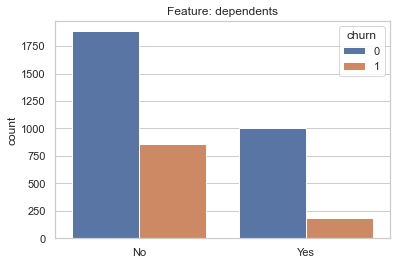

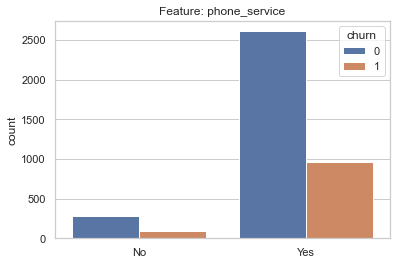

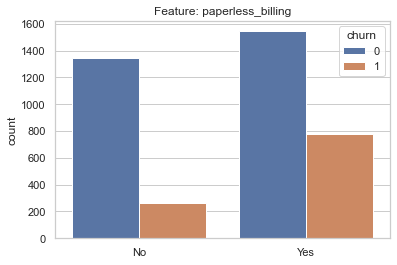

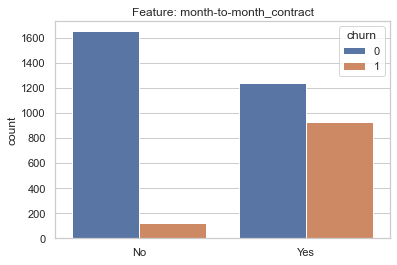

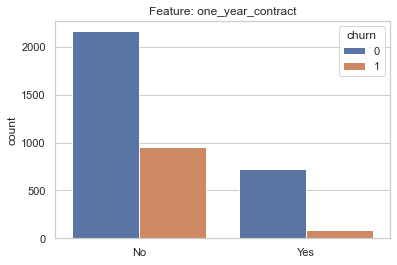

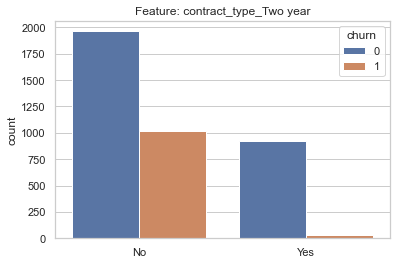

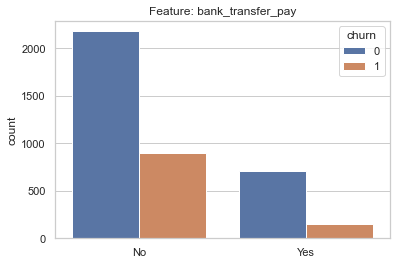

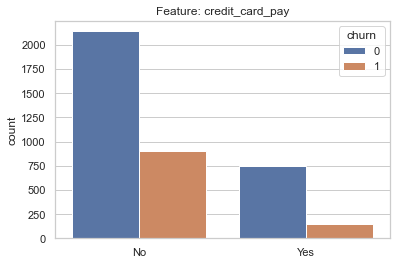

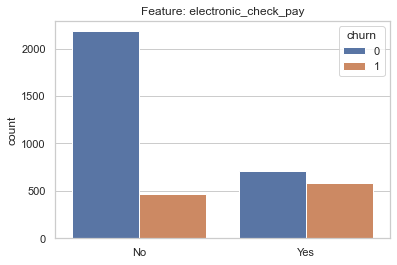

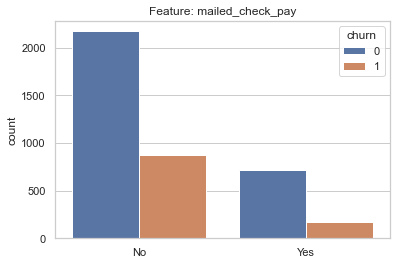

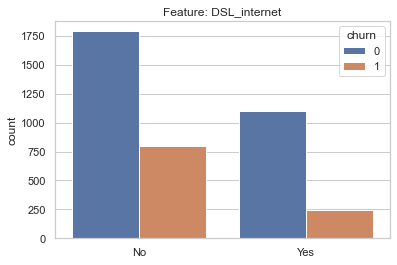

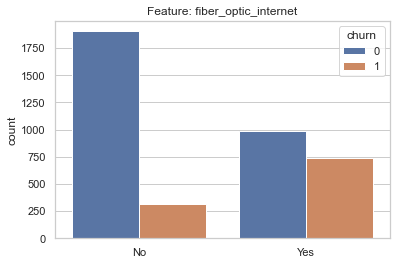

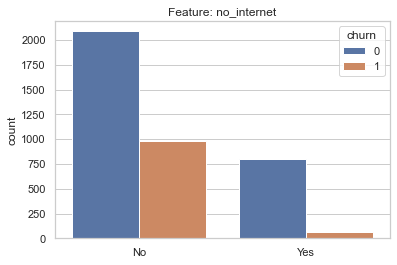

In [16]:
column = train.columns
for col in column:
    if col not in ['customer_id', 'monthly_charges', 'tenure', 'total_charges', 
                   'multiple_lines', 'churn']: 
        sns.set_theme(style="whitegrid")
        ax = sns.countplot(x= train[col], hue="churn",
                           data=train)
        ax.set(xlabel =None)
        ax.set_xticklabels(['No', 'Yes'])
        plt.title(f'Feature: {col}')
        plt.show()

### Takeaways :
- Correlation : 
    - The churn rate on those who are senior citizens is actually rather high, however, there is a very small sample size in comparison to the aggregated count of the entire dataset.
    - Paperlees billing seems to have about a 50% churn rate.
    - month-to-month contracts lose what looks to be about 75% of customers
    - This is the same for electronic checks and fiber optic internet

## Question 1:
### Unexpected Services related to churn : 
- Based on the correlation graph, and count plots a major unexpected feature related to churn would be having fiber optic internet. Because of this obeservation, I will take a look at the internet service types.

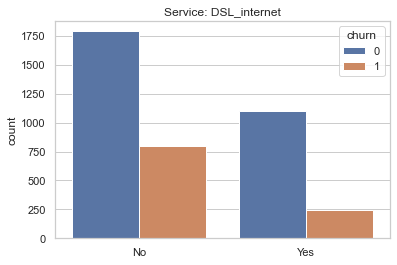

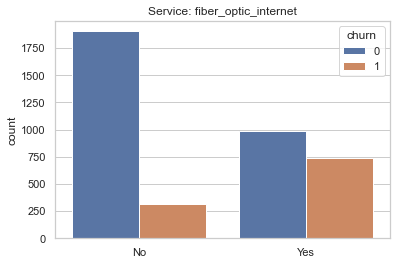

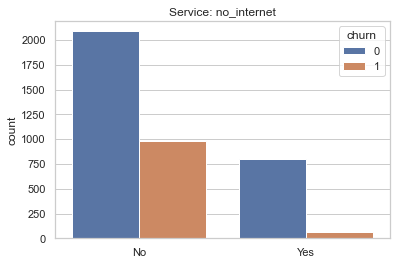

In [17]:
# check internet service types from original telco data

internet_types = ['DSL_internet', 'fiber_optic_internet', 'no_internet']

for types in internet_types:
    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x= train[types], hue="churn",
                       data=train)
    ax.set(xlabel =None)
    ax.set_xticklabels(['No', 'Yes'])
    plt.title(f'Service: {types}')
    plt.show()

### Are those who use mailed checks for payments more or less likely to churn?